Application train shape: (307511, 122)
Application test shape: (48744, 121)
Target distribution:
 TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


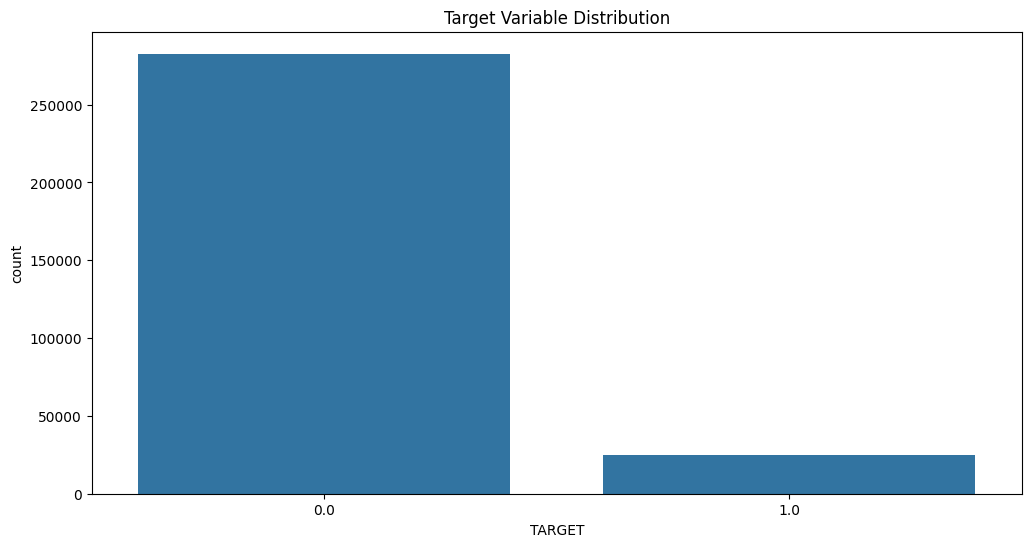

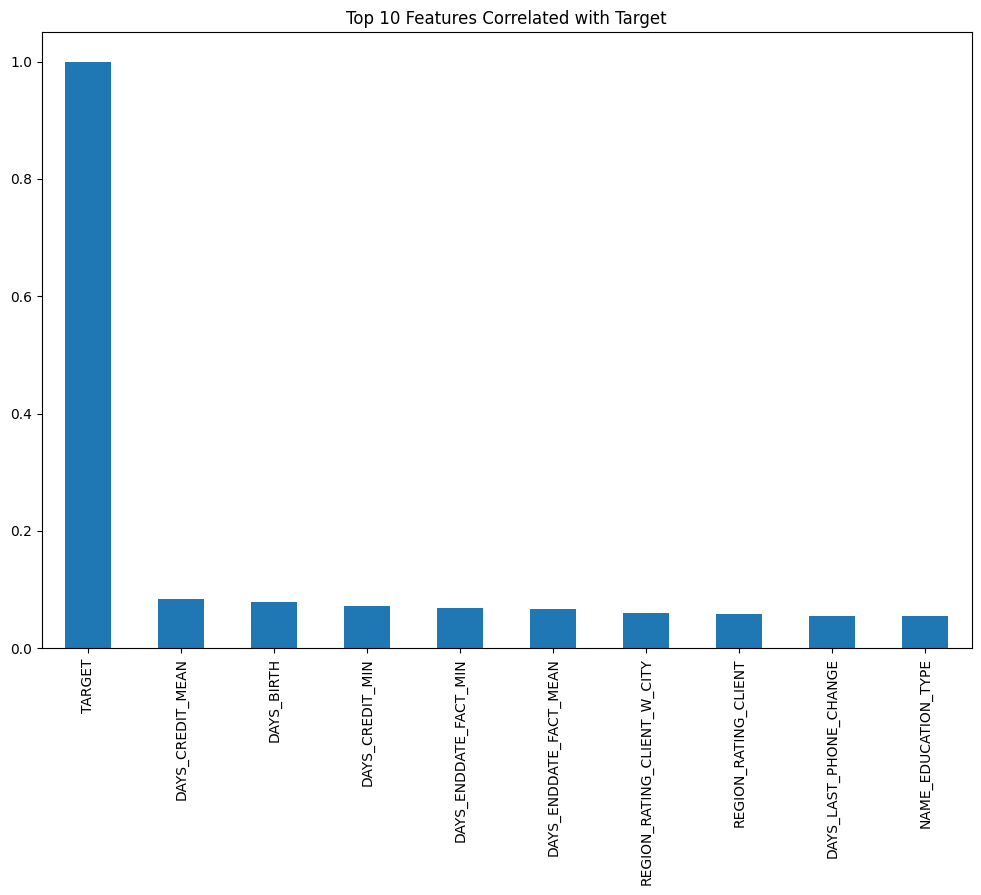

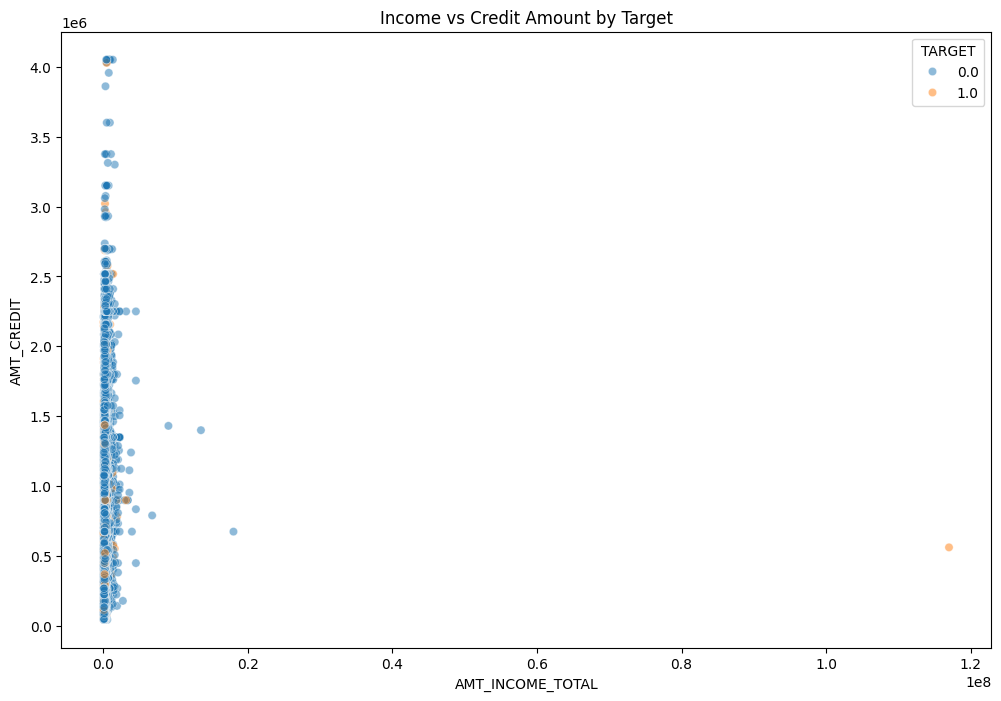

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Load the data
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
credit_card = pd.read_csv('credit_card_balance.csv')
POS = pd.read_csv('POS_CASH_balance.csv')
prev = pd.read_csv('previous_application.csv')
payments = pd.read_csv('installments_payments.csv')

# Data understanding
print("Application train shape:", app_train.shape)
print("Application test shape:", app_test.shape)
print("Target distribution:\n", app_train['TARGET'].value_counts(normalize=True))

# Data cleaning function
def clean_data(df):
    # Handle missing values
    missing_percent = df.isnull().sum() / len(df) * 100
    columns_to_drop = missing_percent[missing_percent > 60].index
    df = df.drop(columns=columns_to_drop)
    
    # Separate numerical and categorical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    # Impute numerical missing values with median
    num_imputer = SimpleImputer(strategy='median')
    df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])
    
    # Impute categorical missing values with mode
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])
    
    # Encode categorical variables
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])
    
    return df

# Clean the main application data
app_train_clean = clean_data(app_train)
app_test_clean = clean_data(app_test)

# Feature engineering for auxiliary data
def aggregate_bureau_data(df):
    # Aggregate bureau data
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({
        'SK_ID_BUREAU': 'count',
        'DAYS_CREDIT': ['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': 'mean',
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': 'mean',
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_ENDDATE_FACT': ['min', 'max', 'mean'],
        'AMT_ANNUITY': ['max', 'mean']
    })
    bureau_agg.columns = ['_'.join(col).upper() for col in bureau_agg.columns]
    bureau_agg.reset_index(inplace=True)
    
    return bureau_agg

# Aggregate all auxiliary data
bureau_agg = aggregate_bureau_data(bureau)

# Merge with main application data
app_train_final = app_train_clean.merge(bureau_agg, on='SK_ID_CURR', how='left')
app_test_final = app_test_clean.merge(bureau_agg, on='SK_ID_CURR', how='left')

# Fill missing values from merged data
app_train_final.fillna(0, inplace=True)
app_test_final.fillna(0, inplace=True)

# EDA and Visualization
plt.figure(figsize=(12, 6))
sns.countplot(x='TARGET', data=app_train_final)
plt.title('Target Variable Distribution')
plt.savefig('target_distribution.png')

# Correlation with target
correlations = app_train_final.corr()['TARGET'].sort_values(ascending=False)
plt.figure(figsize=(12, 8))
correlations.head(10).plot(kind='bar')
plt.title('Top 10 Features Correlated with Target')
plt.savefig('feature_correlation.png')

# Income vs Credit analysis
plt.figure(figsize=(12, 8))
sns.scatterplot(x='AMT_INCOME_TOTAL', y='AMT_CREDIT', hue='TARGET', 
                data=app_train_final, alpha=0.5)
plt.title('Income vs Credit Amount by Target')
plt.savefig('income_vs_credit.png')

# Save processed data
app_train_final.to_csv('processed_train.csv', index=False)
app_test_final.to_csv('processed_test.csv', index=False)